## Tensor-Flow Introduction

You might think of TensorFlow Core programs as consisting of two discrete sections:

>1) **Building** the computational graph (a **tf.Graph**).

>2) **Running** the computational graph (using a **tf.Session**).

A **computational graph** is a series of TensorFlow operations arranged into a graph. The graph is composed of two types of objects.

>1) **Operations** (or "ops"): The **nodes** of the graph. Operations describe calculations that consume and produce tensors.
    
>2) **Tensors**: The **edges** in the graph. These represent the values that will flow through the graph. Most TensorFlow functions return tf.Tensors.


In [74]:
import tensorflow as tf

### 1) Building a simple computational graph

In [2]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0) # also tf.float32 implicitly
total = a + b
print(a)
print(b)
print(total)

Tensor("Const:0", shape=(), dtype=float32)
Tensor("Const_1:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


#### Visualizing the graph

TensorFlow provides a utility called TensorBoard. One of TensorBoard's many capabilities is visualizing a computation graph. Save the computation graph to a TensorBoard summary file. 

In [13]:
writer = tf.summary.FileWriter('./log/')
writer.add_graph(tf.get_default_graph())

This will produce an event file in the log directory. Open tensorboard

```bash
tensorboard --logdir ./log/
```

and open 'http://localhost:6006' in the browser.

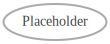

In [3]:
import tfgraphviz as tfg
g = tfg.board(tf.get_default_graph())
g

### 2) Running the graph (Session)

If a tf.Graph is like a .py file, a tf.Session is like the python executable.

The following code creates a tf.Session object and then invokes its run method to evaluate the total tensor we created above:

In [8]:
sess = tf.Session()
print(sess.run({'ab':(a, b), 'total':total}))

{'ab': (3.0, 4.0), 'total': 7.0}


The result shows a different random value on each call to run, but a consistent value during a single run (out1 and out2 receive the same random input):

In [10]:
vec = tf.random_uniform(shape=(3,))
out1 = vec + 1
out2 = vec + 2
print(sess.run(out1))
print(sess.run(out2))
print(sess.run((out1, out2)))

[1.1899425 1.7405813 1.795646 ]
[2.2587063 2.069984  2.790033 ]
(array([1.7642614, 1.355276 , 1.9069761], dtype=float32), array([2.7642612, 2.355276 , 2.9069762], dtype=float32))


### 3) Place holders

A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later, like a function argument.

In [15]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y

We can evaluate this graph with multiple inputs by using the feed_dict argument of the run method to feed concrete values to the placeholders:



In [17]:
print(sess.run(z, feed_dict={x: 3, y: 4.5}))
print(sess.run(z, feed_dict={x: [1, 3], y: [2, 4]}))

7.5
[3. 7.]


### 4) Datasets

Placeholders work for simple experiments that send inputs to network, but ** *Datasets* are the preferred method of streaming data into a model**.

**Remember**

To get a runnable tf.Tensor from a Dataset,
> 1) You must first convert it to a tf.data.Iterator (call *make_one_shot_iterator* method)

> 2) Then call the Iterator's get_next method.

In the following code the next_item tensor will return a row from the my_data array on each run call. Reaching the end of the data stream causes Dataset to throw an OutOfRangeError.

In [24]:
my_data = [
    [0, 1,],
    [2, 3,],
    [4, 5,],
    [6, 7,],
]
slices = tf.data.Dataset.from_tensor_slices(my_data)
next_item = slices.make_one_shot_iterator().get_next()

In [25]:
while True:
  try:
    print(sess.run(next_item))
  except tf.errors.OutOfRangeError:
    break

[0 1]
[2 3]
[4 5]
[6 7]


### 5) Layers

A trainable model must modify the values in the graph to get new outputs with the same input. Layers are the preferred way to add trainable parameters to a graph.

**Remember :**

> 1) We **must set the shape of the input placeholder** so that the layer can build a weight matrix of the correct size.

> 2) A **layer** takes a **batch of input vectors**, and produces output value of dimension **units** for each

**Creating a layer**

```python
output_tensor = tf.layers.Dense(units=1)(input_tensor)
(or)
output_tensor = tf.layers.dense(input_tensor, units=1)
```
The latter approach allows no access to the tf.layers.Layer object. This makes introspection and debugging more difficult, and layer reuse impossible.

In [43]:
x = tf.placeholder(tf.float64,shape=[None,3]) 
linear_model = tf.layers.Dense(units=1)
y = linear_model(x) ## Breaks if shape of X is not specified and ndim(x) >=2

**Remember**

> 3) The layer contains variables that must be initialized before they can be used. While it is possible to initialize variables individually, you can easily initialize all the variables in a TensorFlow graph by passing **tf.global_variables_initializer()** 

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer()) ##Initialize weights
print(sess.run(y, {x: [[1, 2, 3],[4, 5, 6]]}))

[[-3.92317778]
 [-8.5046723 ]]


**Remember :**
> 4) Layer variables must be initialized before running a session on every new output tensor 

In [28]:
z = tf.layers.dense(x, units=1)
sess.run(tf.global_variables_initializer())
print(sess.run(z, {x: [[1, 2, 3],[4, 5, 6]]}))

print(type(tf.layers.dense(x, units=1)))
print(type(tf.layers.Dense(units=1)))

[[1.47966286]
 [3.6210811 ]]
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.layers.core.Dense'>


**Multi-layer perceptron**

In [ ]:
x = tf.placeholder(tf.float64,shape=[None,10]) 
h1 = tf.layers.Dense(8,activation= tf.nn.relu)(x)
h2 = tf.layers.Dense(5,activation= tf.nn.relu)(h1)
h3 = tf.layers.Dense(4,activation= tf.nn.relu)(h2)
y = tf.layers.Dense(1,activation= tf.nn.sigmoid)(h3)

In [42]:
sess = tf.Session()
sess.run(tf.global_variables_initializer()) ##Initialize weights
print(sess.run(y, {x: [[1, 2, 3,2,1,1,2,2,2,2],[4, 5, 6,2,1,2,3,2,1,2]]}))

[[0.44650732]
 [0.40013711]]


### 6) Feature columns

Feature columns is used for conviniently **representing** inputs to the network. This class can be used instead of writing a separate piece of code to attach your data into the network

**Remember**

> 1) The features should be **represented as a dict**, with a unique id for feature names as keys

The following example has a numeric and categorical feature

In [44]:
features = {
    'sales' : [[5], [10], [8], [9]],
    'department': ['sports', 'sports', 'gardening', 'gardening']}


**Remember**

> 2) **tf.feature_column.input_layer** function returns the tensor that should be passed as **input to the network**. This function **only accepts dense columns** as inputs, so **to view the result of a categorical column** you must **wrap it in an tf.feature_column.indicator_column**.

In [45]:
department_column = tf.feature_column.categorical_column_with_vocabulary_list(
        'department', ['sports', 'gardening'])

department_column = tf.feature_column.indicator_column(department_column)


A list of feature_columns is passed on to feature_column.input_layer. In our example, the first feature is of numeric type and second is of categorical type.

In [46]:
feature_columns = [
    tf.feature_column.numeric_column('sales'),
    department_column
]


In [48]:
inputs = tf.feature_column.input_layer(features, feature_columns)
inputs

<tf.Tensor 'input_layer/concat:0' shape=(4, 3) dtype=float32>

**Remember**

> 3) Feature columns can have internal state, like layers, so they often need to be initialized. **Categorical columns** use lookup tables internally and these **require a separate initialization op, tf.tables_initializer**.

In [52]:
var_init = tf.global_variables_initializer()
table_init = tf.tables_initializer()
sess = tf.Session()
sess.run((var_init, table_init))
o = sess.run(inputs)

import pandas as pd
pd.DataFrame(o,columns=["Sport","Gardening","Sales"])

,Sport,Gardening,Sales
0,1.0,0.0,5.0
1,1.0,0.0,10.0
2,0.0,1.0,8.0
3,0.0,1.0,9.0


### 7) Loss Function

In [54]:
y_true = [1,3,2,2]
y_pred = [1,2,1,2]

mse = (1**2 + 1**2)/4.
mse

0.5

In [57]:
te = tf.losses.mean_squared_error(y_true,y_pred)
tf.Session().run(te)

0.5

### 8) Training

Consider the following model :

In [71]:
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
linear_model = tf.layers.Dense(units=1)
y_pred = linear_model(x)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
sess.run(y_pred)


array([[-0.85416746],
       [-1.7083349 ],
       [-2.5625024 ],
       [-3.4166698 ]], dtype=float32)

**Remember :**
> 1) Define **loss function**

> 2) Define **optimizer**

> 3) Run **optimizer.minimize(loss)** (does not return anything)

In [72]:
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

for i in range(10):
  _, loss_value = sess.run((train, loss)) #train does not return anything
  print(loss_value)


0.43034077
0.34296954
0.28207937
0.23956512
0.20980337
0.18889174
0.17412272
0.16361739
0.15607204
0.15058213


### 9) Testing

In [73]:
sess.run(y_pred)

array([[-0.63999385],
       [-1.35748   ],
       [-2.0749664 ],
       [-2.7924526 ]], dtype=float32)